In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
from configs import load_configs, load_experimental_results
from factorization.config import IMAGE_DIR
from factorization.models.mlp import Model

In [9]:
kwargs = {
    # "bernouilli_seed": 0,
    "final": False, # wether to load last epoch only
}
all_configs = load_configs("exp1_dim")
res = load_experimental_results(all_configs, **kwargs)

In [10]:
res['flops'] = Model.get_flops(res['emb_dim'], res['ffn_dim'], res['nb_layers'], res['output_size'])
res['flops'] *= res['epoch']

In [11]:
# study_factors = ['input_factors', 'output_factors']
study_factors = ['emb_dim']
# study_factors = ['nb_layers']
# study_factors = ['data_split']
# study_factors = ['ffn_dim']
# study_factors = ['bernouilli']

all_factors = ['input_factors', 'output_factors', 'parents', 'bernouilli', 'alphas', 'data_split', 'emb_dim', 'ffn_dim', 'nb_layers', 'mode', 'bernouilli_seed', 'seed', 'input_size', 'output_size', 'data_complexity']
ignored = (
    ['seed', 'unique_id', 'loss', 'test_loss', 'batch_size', 'train_entropy', 'test_entropy']
    + list(kwargs.keys())
    + [key for key in all_factors if key not in study_factors]
)
columns = [col for col in res.columns if col not in ignored]

In [28]:
mean = res.groupby(columns)[['loss', 'test_loss']].mean().reset_index()
std = res.groupby(columns)[['loss', 'test_loss']].std().reset_index()

xaxis = 'flops'
# xaxis = 'epoch'
mean.set_index(xaxis, inplace=True)
std.set_index(xaxis, inplace=True)

In [29]:
all_mean = []
all_std = []

keys = study_factors
all_vals = [np.sort(res[key].unique()[::2]).tolist() for key in keys]

for vals in product(*all_vals):
    ind = np.ones(len(mean), dtype=bool)
    for key, val in zip(keys, vals):
        ind &= (mean[key] == val)
    all_mean.append(mean[ind])
    all_std.append(std[ind])

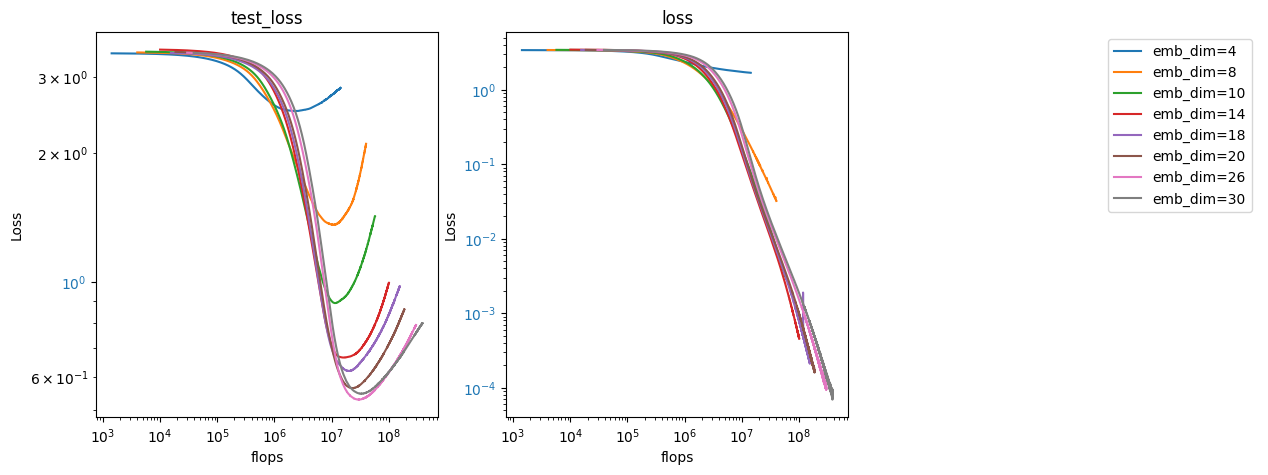

In [30]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, name in zip(axes, ['test_loss', 'loss']):
    color = 'C0'
    legend = []
    all_plots = []
    for val, val_std in zip(all_mean, all_std):
        a, = ax.plot(val[name])
        all_plots.append(a)
        # ax.fill_between(val.index, val[name] - val_std[name], val[name] + val_std[name], alpha=0.5)
        leg = ' '.join([f'{key}={val[key].values[0]}' for key in keys])
        legend.append(leg)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(xaxis)
    ax.set_ylabel('Loss')
    ax.tick_params(axis='y', labelcolor=color)
    ax.set_title(name)
    # ax.set_ylim(4.5, 4.75)

ax = axes[2]
ax.axis('off')
ax.legend(all_plots, legend)

# ax2 = ax.twinx()
# color = 'C1'
# for val, val_std in zip([compression_mean, mean1], [compression_std, std]):
#     ax2.plot(val['nb_factors'], color=color)
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylabel(r'Number $k$ of factors')

ax.grid()
fig.savefig(IMAGE_DIR / f'{study_factors[0]}.pdf')
# ax2.grid(alpha=0.25)